In [60]:
%%capture

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

#### Code below ##### 

%run ML_Record_Mining_JN.ipynb

# Loading libraries for modeling
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Options
pd.options.mode.chained_assignment = None

import time
hide_toggle()

## Simple Modeling for Latitude and Longitude Coordinates

In [54]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'latnorth', 'longeast', 'intersection_words_lat', 'intersection_words_long']]

In [55]:
data['has_both_lat_long_int'] = ((data['intersection_words_lat'].apply(len) != 0) & (data['intersection_words_long'].apply(len) != 0 ))

# Map True to One and False to Zero
data['has_both_lat_long_int'] = data['has_both_lat_long_int'].astype(int)

In [56]:
# Reduce data to columns of interest
data = data[['words_as_string', 'has_both_lat_long_int']]

In [57]:
# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

In [58]:
# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_both_lat_long_int']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_both_lat_long_int']

In [59]:
classifiers = {
    'knn'           : KNeighborsClassifier(),
    'decision tree' : DecisionTreeClassifier(random_state = 0, max_depth = 15),
    'random forest' : RandomForestClassifier(n_estimators = 10),
    'SVM'           : SVC(C = 100, gamma = "scale"),
    'logistic reg'  : LogisticRegression(solver="lbfgs", max_iter = 10000)
#    'sklearn NN'    : MLPClassifier() 
}

In [14]:
train_scores = dict()
test_scores = dict()
training_times = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    classifier_obj.fit(X_train, y_train)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
    test_scores[classifier_name] = classifier_obj.score(X_test, y_test)

Fitting knn
Fitting decision tree
Fitting random forest
Fitting SVM
Fitting logistic reg


In [15]:
pd.options.display.float_format = '{:,.2f}'.format

data = {"train acc": train_scores, "valid acc" : test_scores, "training time (s)" : training_times}
df = pd.DataFrame(data, columns = data.keys())
df.index = list(classifiers.keys())
df

,train acc,valid acc,training time (s)
knn,1.00,1.00,0.01
decision tree,1.00,1.00,0.61
random forest,1.00,1.00,0.73
SVM,1.00,1.00,59.47
logistic reg,1.00,1.00,10.59


We can see there is something really off from the previous data.

Let's try to figure out what could be causing all this noise.

#### Visualizing some possible important features

Using a DecisionTree classifier to see which are the features that are giving more importance.


In [16]:
clf = DecisionTreeClassifier(max_depth = 150)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=150,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
# See which features are considered important
f_imp = clf.feature_importances_

feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [18]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

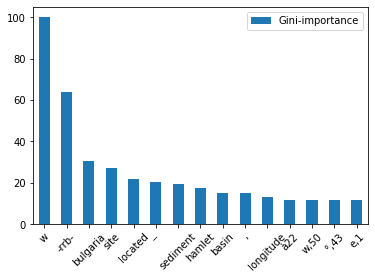

In [19]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:15].plot(kind='bar', rot=45)

In [20]:
Y_pred = clf.predict(X_test)

In [21]:
clf.score(X_test, y_test)

0.9977494373593399

In [22]:
sum((Y_pred-y_test)**2)

48

In [23]:
guessed_label = pd.DataFrame(Y_pred)

In [24]:
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

In [25]:
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

In [26]:
new_data = guessed_label.join(actual_label)
new_data = new_data.drop(columns=['index'])

In [27]:
new_data = new_data.join(original_sentence)
new_data = new_data.drop(columns=['index'])
new_data

,0,has_both_lat_long_int,words_as_string
0,0,0,"S.,neglectus,Csy,."
1,0,0,"RS,and,GIS,The,forested,steep,slopes,of,the,Ac..."
2,0,0,"Hill,,,C.L.,,,1998,."
3,0,0,"Occurrence,and,abundance,of,6-methyl,branched,..."
4,0,0,"J.,Bot,."
...,...,...,...
21323,0,0,"4.2,."
21324,0,0,"Thus,,,after,approximately,1.5,ka,BP,,,the,occ..."
21325,0,0,"Plant,inertia,reassessed,."
21326,0,0,"Troels-Smith,,,J.,,,1955,."


In [ ]:
import os
path = r'/Users/seiryu8808/Desktop/UWinsc/Github/UnacquiredSites/src/output'
output_file = os.path.join(path,'modeled_sentences.tsv')
new_data.to_csv(output_file, sep='\t', index = False)

In [28]:
len(guessed_label)

21328

### Balancing DataSet

We can clearly see that the datasets are very unbalanced. There is not a lot of sentences that have coordinates. Let's try to use only a subset of sentences that do not have coordinates.

In [31]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'latnorth', 'longeast', 'intersection_words_lat', 'intersection_words_long']]

In [32]:
data['has_both_lat_long_int'] = ((data['intersection_words_lat'].apply(len) != 0) & (data['intersection_words_long'].apply(len) != 0 ))

# Map True to One and False to Zero
data['has_both_lat_long_int'] = data['has_both_lat_long_int'].astype(int)

In [33]:
# Reduce data to columns of interest
data = data[['words_as_string', 'has_both_lat_long_int']]
data

,words_as_string,has_both_lat_long_int
0,"Available,online,at,www.sciencedirect.com,Quat...",0
1,"The,Chihuahueños,Bog,record,extends,to,over,15...",0
2,"An,Artemisia,steppe,,,then,an,open,Picea,woodl...",0
3,"C/N,ratios,,,δ13C,and,δ15N,values,indicate,bot...",0
4,"Higher,percentages,of,aquatic,algae,and,elevat...",0
...,...,...
106635,"Ann,.",0
106636,"Sofia,Univ.,.",0
106637,"Fac,.",0
106638,"Geol,.",0


In [34]:
from random import shuffle
data0 = data[data['has_both_lat_long_int'] == 0]
data0 = data0.sample(n = 300)
data1 = data[data['has_both_lat_long_int'] == 1]
data = pd.concat([data0, data1])
data.head(2)

,words_as_string,has_both_lat_long_int
57311,"This,project,was,partially,funded,by,a,Researc...",0
78456,"Ecology,68,,,791e802,.",0


In [35]:
# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

In [36]:
# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_both_lat_long_int']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_both_lat_long_int']

In [37]:
clf = DecisionTreeClassifier(max_depth = 100)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
clf.score(X_test, y_test)

0.8962264150943396

In [39]:
clf.score(X_train, y_train)

0.9976415094339622

In [40]:
# See which features are considered important
f_imp = clf.feature_importances_
feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [41]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

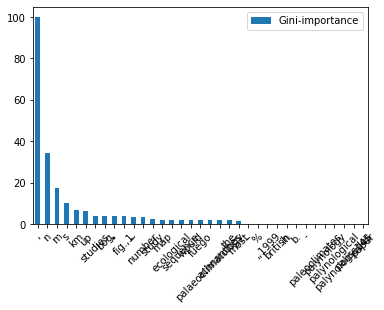

In [42]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:35].plot(kind='bar', rot=45)

In [43]:
importances.sort_values(by='Gini-importance', ascending = False)[:10]

,Gini-importance
",",100.00
n,34.21
m,17.59
s,9.92
km,6.76
up,6.12
studies,3.94
bog,3.91
•,3.88
"fig.,1",3.81


In [46]:
from sklearn.metrics import confusion_matrix
Y_pred = clf.predict(X_test)
confusion_matrix(y_test, Y_pred)

array([[51,  6],
       [ 5, 44]])

In [47]:
Y_pred = clf.predict(X_test)
mse = sum((Y_pred - y_test)**2)
mse

11

In [48]:
guessed_label = pd.DataFrame(Y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

In [49]:
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

In [50]:
new_data = guessed_label.join(actual_label)
new_data = new_data.drop(columns=['index'])

In [51]:
new_data = new_data.join(original_sentence)
new_data = new_data.drop(columns=['index'])
new_data

,0,has_both_lat_long_int,words_as_string
0,0,0,"ﬂuctuate,less,in,earlier,Holocene,sediments,,,..."
1,0,0,"Ecology,67,,,958e966,."
2,1,1,"Sampling,and,analytical,techniques,In,March,20..."
3,1,1,"number,Age,-LRB-,BP,-RRB-,Depth,of,lower,Depth..."
4,1,0,"Pollen,samples,from,41-47,'',N,and,6677,'',W,w..."
...,...,...,...
101,0,0,"The,pattern,of,P.,abies,spread,in,central,Swed..."
102,1,1,"82,L.,Bjo,``,rkman,et,al.,/,Review,of,Palaeobo..."
103,1,0,"51,,,2014,Fig.,1,."
104,1,1,"Kingston,meadow,Kingston,Meadow,-LRB-,2400,m,e..."


In [52]:
import os
output_file = os.path.join(path,'small_model_sentences.tsv')
new_data.to_csv(output_file, sep='\t', index = False)